In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = 'cpu'

cuda


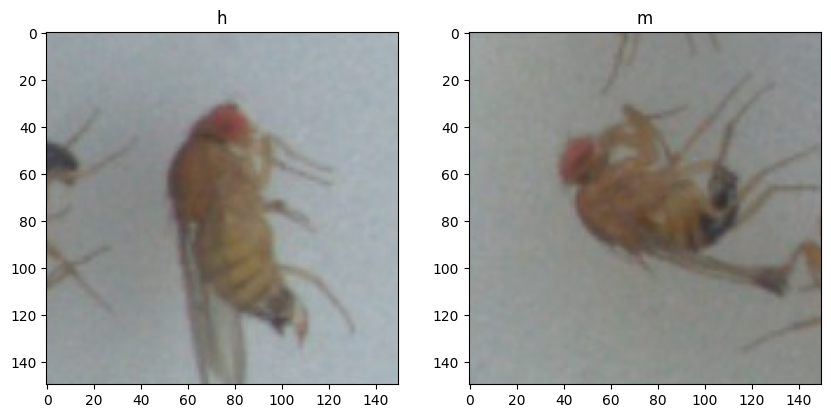

In [3]:
train_folder = './dataset_vgg1/train/'
  
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

In [10]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if device=='cuda':
        model.to(device)
        metric.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if device=='cuda':
                train_data.to(device)
                train_target.to(device)

                optimizer.zero_grad()
                output = model((train_data.cuda()).float())    ## MODIF
                loss = criterion(output, train_target.cuda())   ## MODIF
                epoch_train_loss += loss.item()
                loss.backward()
                optimizer.step()
                accuracy = metric(output, train_target.cuda())
                epoch_train_accuracy += accuracy.item()
            else: 
                optimizer.zero_grad()
                output = model(train_data.float())                 
                loss = criterion(output, train_target)               
                epoch_train_loss += loss.item()
                loss.backward()
                optimizer.step()
                accuracy = metric(output, train_target)
                epoch_train_accuracy += accuracy.item()


        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if device=='cuda':
                valid_data.to(device)
                valid_target.to(device)
                output = model( (valid_data.cuda()).float()) ## MODIF
                epoch_valid_loss += criterion(output, valid_target.cuda()).item() 
                epoch_valid_accuracy += metric(output, valid_target.cuda()).item()
            else:
                output = model(valid_data.float())
                epoch_valid_loss += criterion(output, valid_target).item() 
                epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [11]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 144
ALTO_IMAGENES = 144

In [12]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__() # 144 * 144
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same') # 144 x 144
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # /2 = 72 x 72
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # /2 = 36 x 36
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # /2 = 18 x 18
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # /2 = 9 x 9
        self.fc1 = torch.nn.Linear(in_features=128*9*9, out_features=512)       ## MODIF
        #output_units = 1 ## MODIF 
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)  

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        #return x
        return torch.sigmoid(x) ## MODIF 

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if device=='cuda':
    conv_model.to(device)

#torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

In [13]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='./dataset_vgg1/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='./dataset_vgg1/valid', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [14]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001)


noaug_loss = torch.nn.CrossEntropyLoss()    
#noaug_loss = torch.nn.BCEWithLogitsLoss()    ## MODIF
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                50,
                noaug_writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Epoch: 1/50 - Train loss 0.693564 - Train Accuracy 0.493845 - Valid Loss 0.693135 - Valid Accuracy 0.499354
Epoch: 2/50 - Train loss 0.669763 - Train Accuracy 0.592803 - Valid Loss 0.470147 - Valid Accuracy 0.890238
Epoch: 3/50 - Train loss 0.397544 - Train Accuracy 0.914299 - Valid Loss 0.395341 - Valid Accuracy 0.918518
Epoch: 4/50 - Train loss 0.369688 - Train Accuracy 0.942235 - Valid Loss 0.365278 - Valid Accuracy 0.946927
Epoch: 5/50 - Train loss 0.368836 - Train Accuracy 0.942708 - Valid Loss 0.361118 - Valid Accuracy 0.945377
Epoch: 6/50 - Train loss 0.361283 - Train Accuracy 0.949811 - Valid Loss 0.344567 - Valid Accuracy 0.965909
Epoch: 7/50 - Train loss 0.351703 - Train Accuracy 0.962121 - Valid Loss 0.346983 - Valid Accuracy 0.965909
Epoch: 8/50 - Train loss 0.371922 - Train Accuracy 0.937027 - Valid Loss 0.382333 - Valid Accuracy 0.929881
Epoch: 9/50 - Train loss 0.800429 - Train Accuracy 0.512784 - Valid Loss 0.815199 - Valid Accuracy 0.498063
Epoch: 10/50 - Train loss 0.

KeyboardInterrupt: 

In [ ]:
noaug_conv_model.eval()

In [ ]:
from PIL import Image

def preprocesar_imagen(imagen_path):
    transformacion = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    imagen = Image.open(imagen_path)
    imagen = transformacion(imagen)
    imagen = imagen.unsqueeze(0)  # Agregar dimensión batch
    return imagen

In [ ]:
def predecir_imagen(imagen_path, modelo):
    
    imagen = (preprocesar_imagen(imagen_path)).to(device)

    with torch.no_grad():
        salida = modelo(imagen)
    
    output = (salida.cpu()).numpy()
    
    c = (max(output[0][0], output[0][1])/(output[0][0] + output[0][1]))

    _, indice_prediccion = torch.max(salida, 1)
    
    return indice_prediccion.item(), c

In [ ]:
# ds_dataset/test/017-36.png    MACHO    1
# ds_dataset/test/017-37.png    MACHO    1
# ds_dataset/test/017-42.png    MACHO    1
# ds_dataset/test/023-73.png    HEMBRA    0
# ds_dataset/test/023-75.png    HEMBRA    0
# ds_dataset/test/024-4.png    HEMBRA    0



indice_prediccion = predecir_imagen('./dataset_vgg1/test/m/001-16.png', noaug_conv_model)

print(f'La imagen pertenece a la clase: {indice_prediccion}')

In [ ]:
clases = ['h', 'm']

folder = './dataset_vgg1/test/'

r = 3
  
fig, axs = plt.subplots(r, r, figsize=(20, 20))

axs = axs.flatten()
ok = 0
m = 0
h= 0
mp = 0
hp =0 
for i in axs:

        image_h = random.choice(os.listdir(os.path.join(folder, 'h/')))
        image_m = random.choice(os.listdir(os.path.join(folder, 'm/')))

        
        image_name = random.choice([image_h, image_m])
        
        sex = 'm'
        m = m +1
        file = os.path.join(folder, 'm/', image_m)
        if (image_name==image_h): 
            sex = 'h'
            h=h+1
            m=m-1
            file = os.path.join(folder, 'h/', image_h)
    
        indice_prediccion, c = predecir_imagen(file, noaug_conv_model)

        c = c*100
        #title = sex + " / PRED: " + clases[indice_prediccion]
        #title = sex + (' (ok)' if sex==clases[indice_prediccion] else ' (err)') + f' {c:.2f} %' 
        title = sex + f' {c:.2f} %' 


        #print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        #epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        fg_color = 'red'
        if sex==clases[indice_prediccion]: 
            fg_color = 'green'
            ok += 1
        test_image = mpimg.imread(file)
        
        if clases[indice_prediccion]=='m': 
            mp += 1
        else:
            hp += 1

        i.imshow(test_image)
        i.set_title(title, color= fg_color)
        i.axis("off")



print(f'Imágenes procesadas: {r**2}')
print(f'Cantidad de machos reales/encontrados: {m} / {mp}')
print(f'Cantidad de hembras reales/encontrados: {h} / {hp}')
print(f'Porcentaje correctos: {(ok/(r**2))*100:.2f} %')
